In [1]:
import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
from __future__ import absolute_import,print_function,division
from keras import layers
import keras
import keras.backend as K
from pylab import rcParams
import tensorflow as tf 
import tensorflow.keras as keras
import matplotlib.pyplot as plt 
import numpy as np 
import os
import PIL
import imageio
import glob
import time 

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
%matplotlib inline
from sklearn.utils import shuffle
import random
from sklearn.metrics import precision_recall_fscore_support,accuracy_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import mmd2

In [3]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
pus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)  # 设置显存按需申请
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8192)]) 

In [4]:
seq_len = 30
num_singal = 29
seq_step = 1
value = 0
width = num_singal
height = seq_len
channels = 1
epoch_dura = 5
owner="D"
feature="29"
dp=500

In [5]:
def pca(samples):
    X_n = samples
    ####################################
    ###################################
    # -- the best PC dimension is chosen pc=6 -- #
    n_components = num_singal
    pca = PCA(n_components)
    pca.fit(X_n)
    T_n = pca.transform(X_n)
    ex_var = pca.explained_variance_ratio_
    pc = pca.components_
    # projected values on the principal component
    T_n = np.matmul(X_n, pc.transpose(1, 0))
    samples = T_n
    return samples

In [6]:
def norm(train):
    m, n = train.shape  # m=562387, n=35
    # normalization
    for i in range(n):
        # print('i=', i)
        A = max(train[:, i])-min(train[:, i])
        if A != 0:
#             train[:,i] = train[:,i]-train[:,i].mean()
#             train[:,i] = train[:,i]/train[:,i].std()
            train[:,i] = (train[:,i]-train[:,i].min())/(train[:,i].max()-train[:,i].min())           
#             train[:,i] = train[:,i]*(train[:,i].max()-train[:,i].min())+train[:,i].min()
#             train[:, i] /= max(train[:, i])
#             # scale from -1 to 1
#             train[:, i] = 2 * train[:, i] - 1
        else:
            train[:, i] = train[:, i]
    return train

In [7]:
# train_data_driver=np.load('./data/dataD_drunk_train.npy',allow_pickle=True)
# train_data_driver=norm(train_data_driver)
# train_data_driver = pca(train_data_driver)

# train_data_drivertest=np.load('./data/dataD_drunk_test.npy',allow_pickle=True)
# train_data_drivertest=norm(train_data_drivertest)
# train_data_drivertest = pca(train_data_drivertest)

# test_data=np.load('./data/dataD_drunk_test_anomaly.npy',allow_pickle=True)
# test_data=norm(test_data)
# test_data = pca(test_data)

In [8]:
scaler = MinMaxScaler()
# scaler = StandardScaler()
train_data=np.load('./data/dataD_'+feature+'.npy',allow_pickle=True)
train_data1 = scaler.fit_transform(train_data)
# train_data1=norm(train_data)
train_data1 = pca(train_data1)
####################test data################################
test_data1=np.load('./data/dataA_'+feature+'.npy',allow_pickle=True)
test_data1 = scaler.fit_transform(test_data1)
# test_data=norm(test_data)
test_data1 = pca(test_data1)
# test_data= test_data[test_data.shape[0]//2:,:]

test_data2=np.load('./data/dataB_'+feature+'.npy',allow_pickle=True)
test_data2 = scaler.fit_transform(test_data2)
# test_data=norm(test_data)
test_data2 = pca(test_data2)
# test_data= test_data[test_data.shape[0]//2:,:]

test_data3=np.load('./data/dataC_'+feature+'.npy',allow_pickle=True)
test_data3 = scaler.fit_transform(test_data3)
# test_data=norm(test_data)
test_data3 = pca(test_data3)
# test_data= test_data[test_data.shape[0]//2:,:]

test_data = np.vstack((test_data1,test_data2))
test_data = np.vstack((test_data,test_data3))
#############################################################

train_data_driver = train_data1[:train_data.shape[0]//2,:] #6621
# train_data_driver=norm(train_data_driver)
# train_data_driver = pca(train_data_driver)

train_data_drivertest = train_data1[train_data.shape[0]//2:,:] 
# train_data_drivertest=norm(train_data_drivertest)
# train_data_drivertest = pca(train_data_drivertest)

In [9]:
train_data1.shape

(13243, 29)

In [10]:
a=28

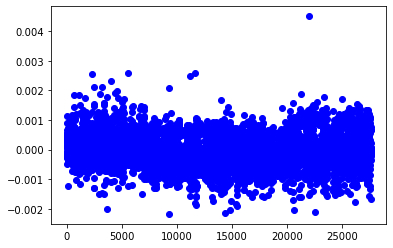

In [11]:
arrange4=np.arange(0, test_data.shape[0], 1, dtype=np.int32)
plt.scatter(range(len(arrange4)),test_data[:,a], c='blue')

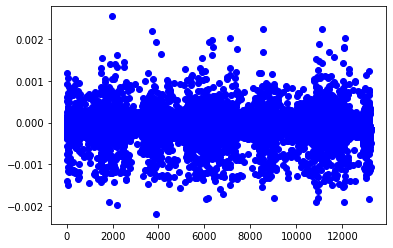

In [12]:
arrange3=np.arange(0, train_data1.shape[0], 1, dtype=np.int32)
plt.scatter(range(len(arrange3)),train_data1[:,a], c='blue')

In [13]:
np.max(train_data_driver)

2.9465320738191965

In [14]:
np.min(train_data_driver)

-1.4663111693726942

In [15]:
np.max(train_data_drivertest)

2.9353761139687915

In [16]:
np.min(train_data_drivertest)

-1.4376691168216902

In [17]:
np.mean(test_data)

-0.008326274592781615

In [18]:
def driver(seq_len, seq_step, num_singal,value):
    ##########################################################
#     train=np.load('./data/dataD.npy',allow_pickle=True)
    train = train_data_driver
    ##########################################################
#     train = norm(train)
#     train = pca(train)
    
    labels = np.full(shape=(len(train)),fill_value=value)
    samples = train

    num_samples = (samples.shape[0] - seq_len) // seq_step
    aa = np.empty([num_samples, seq_len, num_singal])
    bb = np.empty([num_samples, seq_len, 1])


    for j in range(num_samples):
        bb[j, :, :] = np.reshape(labels[(j * seq_step):(j * seq_step + seq_len)], [-1, 1])
        for i in range(num_singal):
            aa[j, :, i] = samples[(j * seq_step):(j * seq_step + seq_len), i]
#         for k in range(num_singal):
#             A = max(aa[j, :, k])-min(aa[j, :, k])
#             if A != 0:
#                 aa[j, :, k] = (aa[j, :, k]-aa[j, :, k].min())/(aa[j, :, k].max()-aa[j, :, k].min())
#             else:
#                 aa[j, :, k] = aa[j, :, k]    

    samples = aa
    index = [i for i in range(len(samples))]
    random.shuffle(index)
    samples = samples[index]
    samples = samples[0:dp]
    samples = np.reshape(samples,[samples.shape[0],samples.shape[1],samples.shape[2],1])
    labels = bb

    return samples, labels

In [19]:
dataD_train,labelD = driver(seq_len, seq_step, num_singal,value)

In [20]:
dataD_train[50,:,:,:]

array([[[ 2.58343176e+00],
        [-7.25360398e-01],
        [ 3.01877005e-01],
        [ 2.97283256e-02],
        [ 2.85442109e-01],
        [-3.38161370e-01],
        [ 4.69377827e-01],
        [ 9.62390122e-02],
        [-1.32266906e-01],
        [-9.31057395e-02],
        [ 2.11450273e-01],
        [ 7.12713467e-01],
        [-2.40426821e-01],
        [-6.97176590e-03],
        [ 1.20265016e-01],
        [-6.61765307e-01],
        [-4.78335901e-01],
        [ 5.60551659e-01],
        [-4.05947259e-01],
        [ 2.02274575e-01],
        [ 1.87645334e-01],
        [-3.57124959e-01],
        [ 1.45302488e-01],
        [-6.65018983e-02],
        [-1.43329749e-02],
        [ 6.65742103e-03],
        [ 1.16209079e-03],
        [ 3.42374933e-04],
        [-2.10661253e-04]],

       [[ 2.60684443e+00],
        [-7.58120749e-01],
        [ 2.96648244e-01],
        [ 5.12249555e-02],
        [ 3.58419281e-01],
        [-3.54833871e-01],
        [ 4.79223253e-01],
        [ 1.35157162e-01],

In [21]:
np.max(dataD_train)

2.9465320738191965

In [22]:
np.min(dataD_train)

-1.4663111693726942

In [23]:
def driver_test():    
#     dataD=np.load('./data/dataD.npy',allow_pickle=True)
    dataD=train_data_drivertest#train_data_drivertest[:6622,]
#     dataB=np.load('./data/dataB.npy',allow_pickle=True)
#     dataH=np.load('./data/dataH.npy',allow_pickle=True)
    dataA=test_data#train_data_drivertest[6622:,]
#     dataH = dataH[2000:,:]
#     dataB=dataB[:3000,:]
#     dataA=np.vstack((dataA,dataB))
#     dataA=np.vstack((dataA,dataH))
#     dataA = dataA[1000:,:]
    dataD_normal = dataD
    dataD_anormaly=dataA
    
#     dataD_contrib = np.vstack((dataD_normal,dataD_anormaly))
#     dataD_contrib = norm(dataD_contrib)
#     dataD_contrib = pca(dataD_contrib)
    label_0 = np.full(shape=(len(dataD_normal)),fill_value=0)
    label_1 = np.full(shape=(len(dataD_anormaly)),fill_value=1)
#     idx = np.asarray(list(range(0, dataD_contrib.shape[0])))
    
#     dataD_normal = dataD_contrib[:dataD_normal.shape[0],:]
#     dataD_anormaly = dataD_contrib[dataD_normal.shape[0]:,:]

    num_samples_0 = (dataD_normal.shape[0] - seq_len) // 1
    aa_0 = np.empty([num_samples_0, seq_len, num_singal])
    bb_0 = np.empty([num_samples_0, seq_len, 1])
    bbb_0 = np.empty([num_samples_0, seq_len, 1])
    for j in range(num_samples_0):
        bb_0[j, :, :] = np.reshape(label_0[(j * 1):(j * 1 + seq_len)], [-1, 1])
        for i in range(num_singal):
            aa_0[j, :, i] = dataD_normal[(j * 1):(j * 1 + seq_len), i]
#         for k in range(num_singal):
#             A = max(aa_0[j, :, k])-min(aa_0[j, :, k])
#             if A != 0:
#                 aa_0[j, :, k] = (aa_0[j, :, k]-aa_0[j, :, k].min())/(aa_0[j, :, k].max()-aa_0[j, :, k].min())
#             else:
#                 aa_0[j, :, k] = aa_0[j, :, k]

    num_samples_1 = (dataD_anormaly.shape[0] - seq_len) // 1
    aa_1 = np.empty([num_samples_1, seq_len, num_singal])
    bb_1 = np.empty([num_samples_1, seq_len, 1])
    bbb_1 = np.empty([num_samples_1, seq_len, 1])
    for j in range(num_samples_1):
        bb_1[j, :, :] = np.reshape(label_1[(j * 1):(j * 1 + seq_len)], [-1, 1])
        for i in range(num_singal):
            aa_1[j, :, i] = dataD_anormaly[(j * 1):(j * 1 + seq_len), i]
#         for k in range(num_singal):
#             A = max(aa_1[j, :, k])-min(aa_1[j, :, k])
#             if A != 0:
#                 aa_1[j, :, k] = (aa_1[j, :, k]-aa_1[j, :, k].min())/(aa_1[j, :, k].max()-aa_1[j, :, k].min())
#             else:
#                 aa_1[j, :, k] = aa_1[j, :, k]

        
        
#     aa_1_A = aa_1[:len(aa_1)//2,:]
#     aa_1_B = aa_1[len(aa_1)//2:,:]
#     bb_1_A = bb_1[:len(aa_1)//2,:]
#     bb_1_B = bb_1[len(aa_1)//2:,:]
#     dataD_test = np.insert(aa_0,1500,aa_1,axis=0)
#     dataD_test = np.insert(dataD_test,5880,aa_1_B,axis=0)
#     labelD_test = np.insert(bb_0,1500,bb_1,axis=0)
#     labelD_test = np.insert(labelD_test,5880,bb_1_B,axis=0)
    dataD_test = np.concatenate((aa_0,aa_1),axis=0)
    labelD_test= np.concatenate((bb_0,bb_1),axis=0)
    labelD_test = np.reshape(labelD_test,[labelD_test.shape[0],labelD_test.shape[1]])
    labelD_test = np.sum(labelD_test,1)
    labelD_test[labelD_test > 1] = 1

    index = [i for i in range(len(dataD_test))]
    random.shuffle(index)
    dataD_test = dataD_test[index]
    labelD_test = labelD_test[index]
    np.save("./score/label_owner"+owner+".npy", labelD_test)

    dataD_test = np.reshape(dataD_test,[dataD_test.shape[0],dataD_test.shape[1],dataD_test.shape[2],1])
    return dataD_test,labelD_test

In [24]:
dataD_test,labelD_test = driver_test()

In [25]:
dataD_test.shape

(34185, 30, 29, 1)

In [26]:
dataD_test[34184,:,:]

array([[[ 1.52931090e+00],
        [-1.21016656e+00],
        [ 1.54297522e-01],
        [ 7.48962031e-01],
        [ 3.35715116e-01],
        [-3.30743231e-01],
        [-5.35913523e-01],
        [-2.06172514e-01],
        [-3.41313480e-01],
        [-3.04149109e-01],
        [ 2.50791974e-01],
        [ 7.51716335e-01],
        [ 2.94031149e-01],
        [-8.24400830e-01],
        [-2.42818340e-01],
        [ 4.12025841e-01],
        [ 4.57481189e-03],
        [-1.05407608e-02],
        [ 4.58244450e-01],
        [ 2.08974160e-03],
        [ 1.96452159e-01],
        [-1.63927255e-02],
        [-1.11939436e-01],
        [-9.82796584e-02],
        [-2.29229930e-02],
        [ 5.52205522e-03],
        [-3.17234357e-04],
        [-2.53140770e-04],
        [ 4.30553236e-04]],

       [[ 1.60359908e+00],
        [-1.30300738e+00],
        [ 2.05286609e-01],
        [ 8.15057812e-01],
        [ 3.19023975e-01],
        [-2.82927326e-01],
        [-5.11979560e-01],
        [-8.40011573e-02],

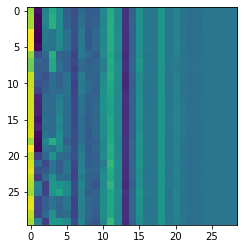

In [27]:
plt.imshow(dataD_test[34184,:,:])
plt.savefig("./picture_std/save/driverD_nopca.png",dpi=600)

In [28]:
# for i in range (13000):
#     if i%100==0:
#         plt.imshow(dataD_test[i,:,:])
#         plt.savefig("./picture_std/driver"+str(i)+".png")

In [29]:
# for i in range (13000):
#     if i%100==0:
#         plt.imshow(dataD_test[i,:,:])
#         plt.savefig("./picture_minmax/driver"+str(i)+".png")

In [30]:
# np.set_printoptions(threshold=np.inf)
dataD_test.shape

(34185, 30, 29, 1)

In [31]:
np.max(dataD_test)

3.34143138517445

In [32]:
np.min(dataD_test)

-1.8765703043388189

In [33]:
model = tf.keras.Sequential()
model.add(layers.Input(name='input', shape=(height, width, channels)))

model.add(layers.Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2'))
model.add(layers.BatchNormalization(name='norm_1'))
model.add(layers.LeakyReLU(name='leaky_2'))

model.add(layers.Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3'))
model.add(layers.BatchNormalization(name='norm_2'))
model.add(layers.LeakyReLU(name='leaky_3'))

model.add(layers.GlobalAveragePooling2D(name='g_encoder_output'))

g_e=model
g_e.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_2 (Conv2D)              (None, 30, 29, 64)        640       
_________________________________________________________________
norm_1 (BatchNormalization)  (None, 30, 29, 64)        256       
_________________________________________________________________
leaky_2 (LeakyReLU)          (None, 30, 29, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 30, 29, 128)       73856     
_________________________________________________________________
norm_2 (BatchNormalization)  (None, 30, 29, 128)       512       
_________________________________________________________________
leaky_3 (LeakyReLU)          (None, 30, 29, 128)       0         
_________________________________________________________________
g_encoder_output (GlobalAver (None, 128)               0

In [34]:
# #Generators Encoder
# input_layer = layers.Input(name='input', shape=(height, width, channels))

# # Encoder
# # x = layers.Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1')(input_layer)
# # x = layers.BatchNormalization(name='norm_0')(x)
# # x = layers.LeakyReLU(name='leaky_1')(x)

# x = layers.Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2')(input_layer)
# x = layers.BatchNormalization(name='norm_1')(x)
# x = layers.LeakyReLU(name='leaky_2')(x)


# x = layers.Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3')(x)
# x = layers.BatchNormalization(name='norm_2')(x)
# x = layers.LeakyReLU(name='leaky_3')(x)


# # x = layers.Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_4', kernel_regularizer = 'l2')(x)
# # x = layers.BatchNormalization(name='norm_3')(x)
# # x = layers.LeakyReLU(name='leaky_4')(x)

# # x = layers.Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_5', kernel_regularizer = 'l2')(x)
# # x = layers.BatchNormalization(name='norm_4')(x)
# # x = layers.LeakyReLU(name='leaky_5')(x)

# x = layers.GlobalAveragePooling2D(name='g_encoder_output')(x)

# g_e = keras.models.Model(inputs=input_layer, outputs=x)

# g_e.summary()

In [35]:
model = tf.keras.Sequential()

model.add(layers.Input(name='input', shape=(128)))
model.add(layers.Dense(height*width, name='dense'))
model.add(layers.Reshape((height, width,1), name='de_reshape'))

model.add(layers.Conv2DTranspose(128, (3,3), strides=(1,1), padding='same', name='deconv_1'))
model.add(layers.LeakyReLU(name='de_leaky_1'))

model.add(layers.Conv2DTranspose(64, (3,3), strides=(1,1), padding='same', name='deconv_2'))
model.add(layers.LeakyReLU(name='de_leaky_2'))

model.add(layers.Conv2DTranspose(channels, (1, 1), strides=(1,1), padding='same', activation='tanh'))
g=model
g.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 870)               112230    
_________________________________________________________________
de_reshape (Reshape)         (None, 30, 29, 1)         0         
_________________________________________________________________
deconv_1 (Conv2DTranspose)   (None, 30, 29, 128)       1280      
_________________________________________________________________
de_leaky_1 (LeakyReLU)       (None, 30, 29, 128)       0         
_________________________________________________________________
deconv_2 (Conv2DTranspose)   (None, 30, 29, 64)        73792     
_________________________________________________________________
de_leaky_2 (LeakyReLU)       (None, 30, 29, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 30, 29, 1)        

In [36]:
# #Generator
# input_layer = layers.Input(name='input', shape=(height, width, channels))

# x = g_e(input_layer)

# y = layers.Dense(height*width, name='dense')(x) # 2 = 128 / 8 / 8
# y = layers.Reshape((height, width,1), name='de_reshape')(y)

# # y = layers.Conv2DTranspose(256, (3,3), strides=(1,1), padding='same', name='deconv_5', kernel_regularizer = 'l2')(y)
# # y = layers.LeakyReLU(name='de_leaky_5')(y)

# # y = layers.Conv2DTranspose(256, (3,3), strides=(1,1), padding='same', name='deconv_0', kernel_regularizer = 'l2')(y)
# # y = layers.LeakyReLU(name='de_leaky_0')(y)

# y = layers.Conv2DTranspose(128, (3,3), strides=(1,1), padding='same', name='deconv_1')(y)
# y = layers.LeakyReLU(name='de_leaky_1')(y)

# y = layers.Conv2DTranspose(64, (3,3), strides=(1,1), padding='same', name='deconv_2')(y)
# y = layers.LeakyReLU(name='de_leaky_2')(y)

# # y = layers.Conv2DTranspose(32, (3,3), strides=(1,1), padding='same', name='deconv_3')(y)
# # y = layers.LeakyReLU(name='de_leaky_3')(y)

# # y = layers.Conv2DTranspose(16, (3,3), strides=(1,1), padding='same', name='deconv_4', kernel_regularizer = 'l2')(y)
# # y = layers.LeakyReLU(name='de_leaky_4')(y)

# y = layers.Conv2DTranspose(channels, (1, 1), strides=(1,1), padding='same', activation='tanh')(y)

# g = keras.models.Model(inputs=input_layer, outputs=y)

# g.summary()

In [37]:
model = tf.keras.Sequential()

model.add(layers.Input(name='input', shape=(height, width, channels)))

model.add(layers.Conv2D(64, (3,3), strides=(1,1), padding='same', name='encoder_conv_2'))
model.add(layers.BatchNormalization(name='encoder_norm_1'))
model.add(layers.LeakyReLU())

model.add(layers.Conv2D(128, (3,3), strides=(1,1), padding='same', name='encoder_conv_3'))
model.add(layers.BatchNormalization(name='encoder_norm_2'))
model.add(layers.LeakyReLU())

model.add(layers.GlobalAveragePooling2D(name='encoder_output'))
encoder = model
encoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_conv_2 (Conv2D)      (None, 30, 29, 64)        640       
_________________________________________________________________
encoder_norm_1 (BatchNormali (None, 30, 29, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 30, 29, 64)        0         
_________________________________________________________________
encoder_conv_3 (Conv2D)      (None, 30, 29, 128)       73856     
_________________________________________________________________
encoder_norm_2 (BatchNormali (None, 30, 29, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 30, 29, 128)       0         
_________________________________________________________________
encoder_output (GlobalAverag (None, 128)              

In [38]:
# #Encoder
# input_layer = layers.Input(name='input', shape=(height, width, channels))

# # z = layers.Conv2D(32, (3,3), strides=(1,1), padding='same', name='encoder_conv_1')(input_layer)
# # z = layers.BatchNormalization(name='encoder_norm_0')(z)
# # z = layers.LeakyReLU()(z)

# z = layers.Conv2D(64, (3,3), strides=(1,1), padding='same', name='encoder_conv_2')(input_layer)
# z = layers.BatchNormalization(name='encoder_norm_1')(z)
# z = layers.LeakyReLU()(z)


# z = layers.Conv2D(128, (3,3), strides=(1,1), padding='same', name='encoder_conv_3')(z)
# z = layers.BatchNormalization(name='encoder_norm_2')(z)
# z = layers.LeakyReLU()(z)

# # z = layers.Conv2D(256, (3,3), strides=(1,1), padding='same', name='encoder_conv_4', kernel_regularizer = 'l2')(z)
# # z = layers.BatchNormalization(name='encoder_norm_3')(z)
# # z = layers.LeakyReLU()(z)


# # z = layers.Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_41', kernel_regularizer = 'l2')(z)
# # z = layers.BatchNormalization(name='encoder_norm_4')(z)
# # z = layers.LeakyReLU()(z)

# z = layers.GlobalAveragePooling2D(name='encoder_output')(z)

# encoder = keras.models.Model(input_layer, z)
# encoder.summary()

In [39]:
model = tf.keras.Sequential()

model.add(layers.Input(name='input', shape=(height, width, channels)))

model.add(layers.Conv2D(64, (3,3), strides=(1,1), padding='same', name='f_conv_2'))
model.add(layers.BatchNormalization(name='f_norm_1'))
model.add(layers.LeakyReLU(name='f_leaky_2'))

model.add(layers.Conv2D(128, (3,3), strides=(1,1), padding='same', name='f_conv_3'))
model.add(layers.BatchNormalization(name='f_norm_2'))
model.add(layers.LeakyReLU(name='f_leaky_3'))

feature_extractor = model
feature_extractor.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
f_conv_2 (Conv2D)            (None, 30, 29, 64)        640       
_________________________________________________________________
f_norm_1 (BatchNormalization (None, 30, 29, 64)        256       
_________________________________________________________________
f_leaky_2 (LeakyReLU)        (None, 30, 29, 64)        0         
_________________________________________________________________
f_conv_3 (Conv2D)            (None, 30, 29, 128)       73856     
_________________________________________________________________
f_norm_2 (BatchNormalization (None, 30, 29, 128)       512       
_________________________________________________________________
f_leaky_3 (LeakyReLU)        (None, 30, 29, 128)       0         
Total params: 75,264
Trainable params: 74,880
Non-trainable params: 384
________________________________________________

In [40]:
# #feature extractor
# input_layer = layers.Input(name='input', shape=(height, width, channels))

# # f = layers.Conv2D(32, (3,3), strides=(1,1), padding='same', name='f_conv_1')(input_layer)
# # f = layers.BatchNormalization(name='f_norm_0')(f)
# # f = layers.LeakyReLU(name='f_leaky_1')(f)
# # f = layers.Dropout(0.3)(f)

# f = layers.Conv2D(64, (3,3), strides=(1,1), padding='same', name='f_conv_2')(input_layer)
# f = layers.BatchNormalization(name='f_norm_1')(f)
# f = layers.LeakyReLU(name='f_leaky_2')(f)
# # f = layers.Dropout(0.3)(f)

# f = layers.Conv2D(128, (3,3), strides=(1,1), padding='same', name='f_conv_3')(f)
# f = layers.BatchNormalization(name='f_norm_2')(f)
# f = layers.LeakyReLU(name='f_leaky_3')(f)
# # f = layers.Dropout(0.3)(f)

# # f = layers.Conv2D(256, (3,3), strides=(1,1), padding='same', name='f_conv_4', kernel_regularizer = 'l2')(f)
# # f = layers.BatchNormalization(name='f_norm_3')(f)
# # f = layers.LeakyReLU(name='f_leaky_4')(f)
# # f = layers.Dropout(0.3)(f)

# # f = layers.Conv2D(256, (3,3), strides=(1,1), padding='same', name='f_conv_5', kernel_regularizer = 'l2')(f)
# # f = layers.BatchNormalization(name='f_norm_4')(f)
# # f = layers.LeakyReLU(name='feature_output')(f)

# feature_extractor = keras.models.Model(input_layer, f)

# feature_extractor.summary()

In [41]:
#gan trainer
class AdvLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AdvLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori_feature = feature_extractor(x[0])
        gan_feature = feature_extractor(x[1])
        return K.mean(K.square(ori_feature - K.mean(gan_feature, axis=0)))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
class CntLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CntLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori = x[0]
        gan = x[1]
        return K.mean(K.abs(ori - gan))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
class EncLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(EncLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori = x[0]
        gan = x[1]
        return K.mean(K.square(g_e(ori) - encoder(gan)))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
# model for training
input_layer = layers.Input(name='input', shape=(height, width, channels))
gan = g(g_e(input_layer)) # g(x)

adv_loss = AdvLoss(name='adv_loss')([input_layer, gan])
cnt_loss = CntLoss(name='cnt_loss')([input_layer, gan])
enc_loss = EncLoss(name='enc_loss')([input_layer, gan])

gan_trainer = keras.models.Model(input_layer, [adv_loss, cnt_loss, enc_loss])

# loss function
def loss(yt, yp):
    return yp

losses = {
    'adv_loss': loss,
    'cnt_loss': loss,
    'enc_loss': loss,
}

lossWeights = {'cnt_loss': 20.0, 'adv_loss': 1.0, 'enc_loss': 1.0}

# compile
gan_trainer.compile(optimizer = 'adam', loss=losses, loss_weights=lossWeights)

In [42]:
gan_trainer.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 30, 29, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          75264       input[0][0]                      
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 30, 29, 1)    187367      sequential[0][0]                 
__________________________________________________________________________________________________
adv_loss (AdvLoss)              ()                   0           input[0][0]                      
                                                                 sequential_1[0][0]           

In [43]:
# model = tf.keras.Sequential()
# model.add(layers.Input(name='input', shape=(height, width, 128)))
# # model.add(layers.Flatten())
# model.add(layers.GlobalAveragePooling2D(name='glb_avg'))
# model.add(layers.Dense(1, activation='sigmoid', name='d_out'))

# d=model
# d.summary()

In [44]:
#discriminator

input_layer = layers.Input(name='input', shape=(height, width, channels))

f = feature_extractor(input_layer)
# d = layers.Flatten()(f)
d = layers.GlobalAveragePooling2D(name='glb_avg')(f)
d = layers.Dense(1, activation='sigmoid', name='d_out')(d)
# d = layers.Dense(1, name='d_out')(d)    
d = keras.models.Model(input_layer, d)
d.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 30, 29, 1)]       0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 30, 29, 128)       75264     
_________________________________________________________________
glb_avg (GlobalAveragePoolin (None, 128)               0         
_________________________________________________________________
d_out (Dense)                (None, 1)                 129       
Total params: 75,393
Trainable params: 75,009
Non-trainable params: 384
_________________________________________________________________


In [45]:
d.compile(optimizer='adam', loss='binary_crossentropy')

In [46]:
def Evaluation(data,label,epoch):
    #Evaluation
    encoded = g_e.predict(data)
    gan_x = g.predict(g_e.predict(data))
    encoded_gan = g_e.predict(gan_x)
    score = np.sum(np.absolute(encoded - encoded_gan), axis=-1)
    score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1
#     np.save("./score/driver"+str(epoch)+"_"+str(height)+".npy", score)
#     D_L = np.empty([score.shape[0], ])
#     for i in range(score.shape[0]):
#         if score[i]>np.percentile(score, 75):
#             # true/negative
#             D_L[i] = 1
#         else:
#             # false/positive
#             D_L[i] = 0
    # fpr, tpr, thresholds = metrics.roc_curve(labelAF, D_L, pos_label = 0)
    # Auc = metrics.auc(fpr, tpr)
#     precision, recall, f1, _ = precision_recall_fscore_support(labelD_test, D_L, average='binary')        
    rcParams['figure.figsize'] = 14, 5
    plt.scatter(range(len(score)),score, c=['skyblue' if x == 0 else 'pink' for x in label])
    plt.savefig("./plot/driver"+str(epoch)+"_"+str(height)+".png")
    plt.clf()
    plt.close()
    return score
# def Evaluation():    
#     score = np.empty([labelD_test.shape[0]])
#     for i in range(len(dataD_test)):
#         a=0
#         test = np.reshape(dataD_test[i],[1,dataD_test[i].shape[0],dataD_test[i].shape[1],dataD_test[i].shape[2]])
#         dis=d(test)
#         if dis > 0:
#             a=0
#         else:
#             a=1
#         score[i]=a
#     return score

In [47]:
def save_data(x,fake_x,epoch):
    x=np.reshape(x,[x.shape[0],x.shape[1],x.shape[2]])
    fake_x=np.reshape(fake_x,[fake_x.shape[0],fake_x.shape[1],fake_x.shape[2]])
    np.save("./save_data/driver_ori"+str(epoch)+"_"+str(height)+".npy", x)
    np.save("./save_data/driver_fake"+str(epoch)+"_"+str(height)+".npy", fake_x)

In [48]:
#Training

niter = 100
arrange=np.arange(0, niter, 1, dtype=np.int32)
bz = 64
def get_data_generator(data, batch_size=bz):
    datalen = len(data)
    cnt = 0
    while True:
        idxes = np.arange(datalen)
        np.random.shuffle(idxes)
        cnt += 1
        for i in range(int(np.ceil(datalen/batch_size))):
            train_x = np.take(data, idxes[i*batch_size: (i+1) * batch_size], axis=0)
            y = np.ones(len(train_x))
            yield train_x, [y, y, y]        

In [49]:
def plot_loss(g_loss,d_loss):
#     plt.figure(figsize=(14,5),dpi=100,linewidth = 4)
#     plt.plot(arrange,g_loss[:,0],'b', c='red',label = "cnt_loss")
#     plt.plot(arrange,g_loss[:,1],'b', c='blue',label = "cnt1_loss")
#     plt.plot(arrange,g_loss[:,2],'b', c='orange',label = "adv_loss")
#     plt.plot(arrange,g_loss[:,3],'b', c='green',label = "enc_loss")
#     plt.plot(arrange,d_loss, 'b',c='pink',label = "d_loss")
#     plt.xlabel("loss", fontsize=10, labelpad = 15)
#     plt.ylabel("epoch", fontsize=10, labelpad = 20)
#     plt.legend(loc = "best", fontsize=10)
#     plt.savefig("./trace/driver_"+str(height)+".png")
    np.save("./trace/driver_gloss"+str(height)+".npy", g_loss)
    np.save("./trace/driver_dloss"+str(height)+".npy", d_loss)

In [50]:
train_data_generator = get_data_generator(dataD_train, bz)

In [51]:
dataD_train=dataD_train.astype('float32')
dataD_train1=dataD_train[0:((dataD_train.shape[0])-((dataD_train.shape[0])%bz)),:,:,:]
train_dataset = tf.data.Dataset.from_tensor_slices(dataD_train1).shuffle(dataD_train1.shape[0]).batch(bz)

In [52]:
train_dataset

<BatchDataset shapes: (None, 30, 29, 1), types: tf.float32>

In [53]:
x, y = train_data_generator.__next__() 

In [54]:
dataD_train.shape

(500, 30, 29, 1)

In [55]:
%%time
g_loss_plot = np.empty([niter,4])
d_loss_plot = np.empty([niter])
score1 =np.empty([labelD_test.shape[0]])
trace = open("./trace/driver_trace"+str(height)+".txt", 'w')
for i in range(niter):
    start = time.time()
    ### get batch x, y ###
#     x, y = train_data_generator.__next__() 
    for image_batch in train_dataset:
            ### train disciminator ###
            d.trainable = True
            
            
            fake_x = g.predict(g_e.predict(image_batch))

            d_x = np.concatenate([image_batch, fake_x], axis=0)
            d_y = np.concatenate([np.zeros(len(image_batch)), np.ones(len(fake_x))], axis=0)

            d_loss = d.train_on_batch(d_x, d_y)

            ### train generator ###

            d.trainable = False        
            g_loss = gan_trainer.train_on_batch(image_batch, y)

    g_loss_plot[i]=g_loss
    d_loss_plot[i]=d_loss
    if i % epoch_dura == 0:
        score=Evaluation(dataD_test,labelD_test,i)
#         score=Evaluation()
        score1 = np.vstack((score1,score))
        np.save("./score/score_owner"+owner+".npy", score1)
#         save_data(x,fake_x,i)
#         trace.write(f'niter: {i+1}, g_loss: {g_loss}, d_loss: {d_loss}\n\n')
    print ('Time for epoch {} is {} sec'.format(i + 1, time.time()-start))
plot_loss(g_loss_plot,d_loss_plot)

Time for epoch 1 is 8.67765188217163 sec
Time for epoch 2 is 0.5261564254760742 sec
Time for epoch 3 is 0.5292088985443115 sec
Time for epoch 4 is 0.5287058353424072 sec
Time for epoch 5 is 0.5290522575378418 sec
Time for epoch 6 is 5.445605039596558 sec
Time for epoch 7 is 0.526329517364502 sec
Time for epoch 8 is 0.5364761352539062 sec
Time for epoch 9 is 0.5455067157745361 sec
Time for epoch 10 is 0.5545167922973633 sec
Time for epoch 11 is 5.599174499511719 sec
Time for epoch 12 is 0.5252878665924072 sec
Time for epoch 13 is 0.5325961112976074 sec
Time for epoch 14 is 0.5271956920623779 sec
Time for epoch 15 is 0.5315773487091064 sec
Time for epoch 16 is 5.51401948928833 sec
Time for epoch 17 is 0.5210378170013428 sec
Time for epoch 18 is 0.5299868583679199 sec
Time for epoch 19 is 0.5301380157470703 sec
Time for epoch 20 is 0.5284700393676758 sec
Time for epoch 21 is 5.493415832519531 sec
Time for epoch 22 is 0.5255467891693115 sec
Time for epoch 23 is 0.5290770530700684 sec
Time 

In [56]:
D_L = np.empty([score1.shape[1]])
precisiona = np.empty([score1.shape[0]-1])
recalla = np.empty([score1.shape[0]-1])
f1a = np.empty([score1.shape[0]-1])
acca = np.empty([score1.shape[0]-1])
for j in range (score1.shape[0]-1):
    for i in range(score1.shape[1]):
        if score1[j+1][i]>0.3:
            # true/negative
            D_L[i] = 1
        else:
            # false/positive
            D_L[i] = 0
    precisiona[j], recalla[j], f1a[j], _ = precision_recall_fscore_support(labelD_test, D_L, average='binary')
    acca[j] = accuracy_score(labelD_test, D_L)

In [57]:
score1.shape

(21, 34185)

In [58]:
acca

array([0.76378529, 0.74664326, 0.72809712, 0.72242211, 0.76246892,
       0.81348545, 0.80827848, 0.91525523, 0.86523329, 0.90668422,
       0.91420214, 0.91589879, 0.90870265, 0.90536785, 0.86438496,
       0.91581103, 0.93421091, 0.9065087 , 0.95971918, 0.9385988 ])

In [59]:
# start = time.time()
# encoded = g_e.predict(dataD_test)
# gan_x = g.predict(dataD_test)
# encoded_gan = g_e.predict(gan_x)
# score = np.sum(np.absolute(encoded - encoded_gan), axis=-1)
# score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1
# print ('Time for epoch {} is {} sec'.format(1, time.time()-start))

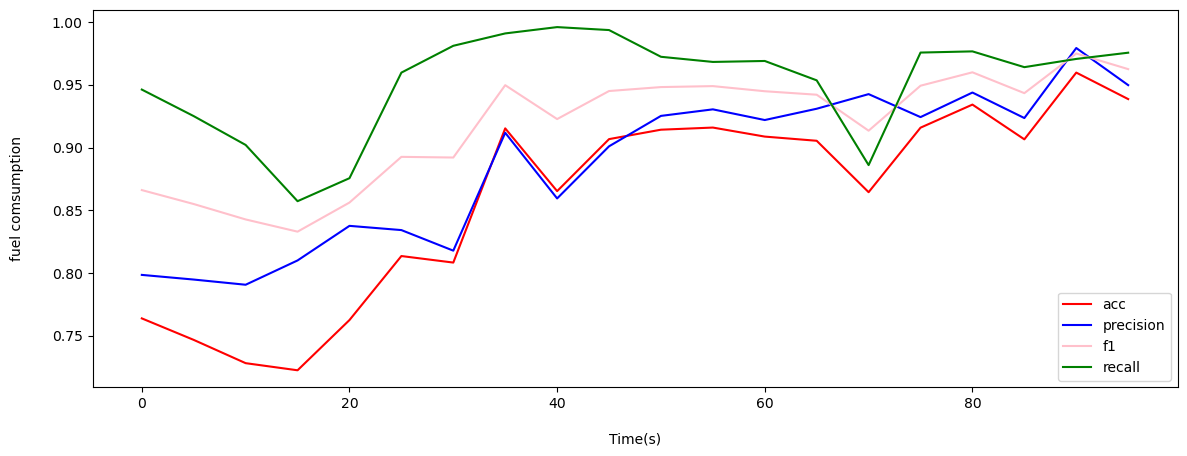

In [60]:
arrange=np.arange(0, 100, 5,dtype=np.int32)
# arrange1=np.arange(0, 4000, 1, dtype=np.int32)
plt.figure(figsize=(14,5),dpi=100,linewidth = 4)
plt.plot(arrange,acca,'b', c='red',label = "acc")
plt.plot(arrange,precisiona,'b', c='blue',label = "precision")
plt.plot(arrange,f1a,'b', c='pink',label = "f1")
plt.plot(arrange,recalla,'b', c='green',label = "recall")
# plt.plot(arrange1,g_loss_plot[:,3], 'b',c='black',label = "g_loss")
# plt.plot(arrange1,d_loss_plot, 'b',c='pink',label = "d_loss")
plt.xlabel("Time(s)", fontsize=10, labelpad = 15)
plt.ylabel("fuel comsumption", fontsize=10, labelpad = 20)
plt.legend(loc = "best", fontsize=10)
# plt.savefig("./picture/driverA&D_fuel comsumption.png")

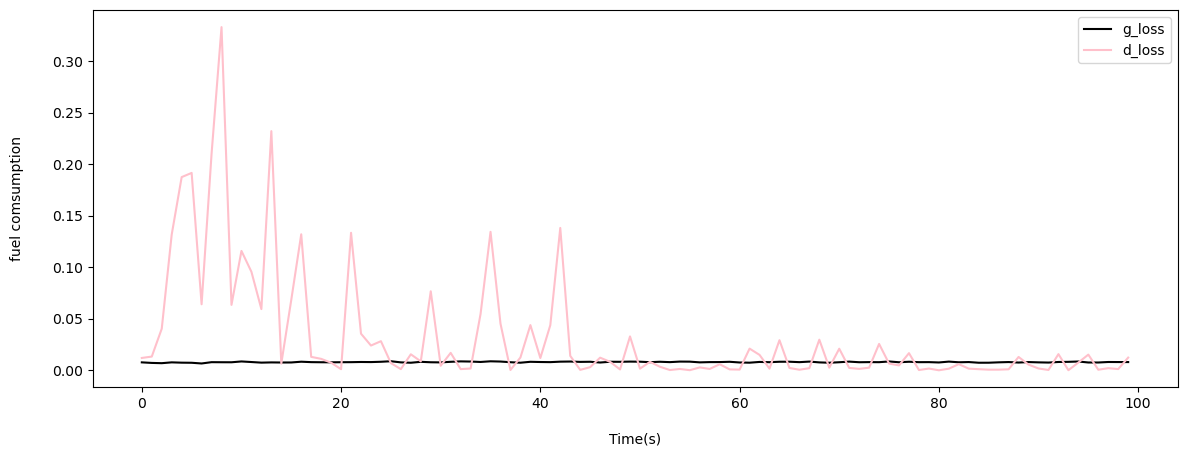

In [63]:
arrange1=np.arange(0, 100, 1, dtype=np.int32)
plt.figure(figsize=(14,5),dpi=100,linewidth = 4)
plt.plot(arrange1,g_loss_plot[:,3], 'b',c='black',label = "g_loss")
plt.plot(arrange1,d_loss_plot, 'b',c='pink',label = "d_loss")
plt.xlabel("Time(s)", fontsize=10, labelpad = 15)
plt.ylabel("fuel comsumption", fontsize=10, labelpad = 20)
plt.legend(loc = "best", fontsize=10)
# plt.savefig("./picture/driverA&D_fuel comsumption.png")

In [50]:
acca

array([0.77247331, 0.75512652, 0.79207255, 0.79719175, 0.76115255,
       0.86093316, 0.76475062, 0.87304373, 0.84917361, 0.89290625,
       0.53146117, 0.77402369, 0.72054995, 0.71531373, 0.71592804,
       0.71584028, 0.71882405, 0.71733216, 0.71592804, 0.71633757,
       0.71619131, 0.7166301 , 0.71832675, 0.71777095, 0.71507971,
       0.71428989, 0.71853152, 0.71736142, 0.71537224, 0.72072546,
       0.71923358, 0.7165716 , 0.71197894, 0.71174492, 0.70966798,
       0.70987275, 0.70826386, 0.70996051, 0.71034079, 0.71077958])

In [51]:
precisiona

array([0.80027277, 0.79658088, 0.82863285, 0.80522397, 0.80367638,
       0.8615711 , 0.80496022, 0.87474617, 0.8616188 , 0.88954359,
       0.73484541, 0.8659471 , 0.85295038, 0.85414601, 0.85390279,
       0.8538014 , 0.8547248 , 0.85443188, 0.85325958, 0.85375978,
       0.85325593, 0.85381758, 0.85471132, 0.85429418, 0.85342677,
       0.85271072, 0.85449955, 0.8548585 , 0.85267522, 0.85526419,
       0.85463718, 0.85232997, 0.8501085 , 0.8499783 , 0.84809678,
       0.84929449, 0.84830395, 0.85128368, 0.85136048, 0.85242834])

In [52]:
f1a

array([0.87162474, 0.86048101, 0.87903336, 0.88715269, 0.86295967,
       0.91966338, 0.8651757 , 0.92596131, 0.91203767, 0.93721596,
       0.69339   , 0.85887576, 0.82026002, 0.81571672, 0.81627788,
       0.81623156, 0.81842911, 0.81728969, 0.81643763, 0.81664681,
       0.81665281, 0.81687052, 0.81802891, 0.81768018, 0.81570482,
       0.81523939, 0.81824707, 0.81720837, 0.81613062, 0.81983733,
       0.81878257, 0.81719213, 0.81400884, 0.81385069, 0.81263333,
       0.81249291, 0.81142814, 0.81205573, 0.81234839, 0.81243716])

In [53]:
recalla

array([0.9569456 , 0.93552713, 0.93596202, 0.98764179, 0.93168557,
       0.98615591, 0.93512847, 0.98354655, 0.96872395, 0.99028739,
       0.65636212, 0.85191896, 0.78998297, 0.78059653, 0.78182872,
       0.78182872, 0.78509042, 0.78324213, 0.78266227, 0.78262603,
       0.78306092, 0.78298844, 0.7843656 , 0.78407567, 0.78117639,
       0.7809227 , 0.78494546, 0.78273475, 0.78258979, 0.78722864,
       0.78581524, 0.78483673, 0.78085022, 0.78066901, 0.78001667,
       0.77874823, 0.77762476, 0.77628384, 0.77675497, 0.77603015])

In [54]:
# scorea=np.load('./score/ownerB/score_ownerB.npy',allow_pickle=True)
# labela_test=np.load('./score/ownerB/label_ownerB.npy',allow_pickle=True)
# scoreb=np.load('./score/ownerB/score_ownerB.npy',allow_pickle=True)
# labelb_test=np.load('./score/ownerB/label_ownerB.npy',allow_pickle=True)
# scorec=np.load('./score/ownerC/score_ownerC.npy',allow_pickle=True)
# labelc_test=np.load('./score/ownerC/label_ownerC.npy',allow_pickle=True)
# scored=np.load('./score/ownerD/score_ownerD.npy',allow_pickle=True)
# labeld_test=np.load('./score/ownerD/label_ownerD.npy',allow_pickle=True)